## Gather the data

In [49]:
import numpy as np
import pickle
from simtk.openmm import unit
from openmmtools.constants import kB
import pandas as pd

import matplotlib.pyplot as plt
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [50]:
def compute_ddg(apo_dg, complex_dg):
    return complex_dg * KT_KCALMOL - apo_dg * KT_KCALMOL

def compute_error(apo_ddg, complex_ddg):
    return (apo_ddg**2 + complex_ddg**2)**0.5 * KT_KCALMOL

In [51]:
# Retrieve free energies

replicate = 1
main_dir = 47
sub_dirs = list(range(0, 4)) + list(range(5, 12)) + list(range(13, 17)) + list(range(18, 28))

d_results = {}
for sub_dir in sub_dirs:
    d_results[sub_dir] = {}
    for phase in ['apo', 'complex']:
        if phase == "complex":
            length = 50
        else:
            length = 10
        with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{phase}_free_energy_bootstrapped_{length}ns.pickle", "rb") as f:
            results = pickle.load(f)
            d_results[sub_dir][phase] = results

main_dir = 45
d_mapping = {4: 11, 12: 10, 17: 9}
for sub_dir in d_mapping.keys():
    d_results[sub_dir] = {}
    if sub_dir == 4:
        replicate = 0
    else:
        replicate = 1
    for phase in ['apo', 'complex']:
        if phase == "complex":
            length = 50
        else:
            length = 10
        with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{d_mapping[sub_dir]}/replicate_{replicate}/{phase}_free_energy_bootstrapped_{length}ns.pickle", "rb") as f:
            results = pickle.load(f)
            d_results[sub_dir][phase] = results
        

In [52]:
d_results[12]["complex"]["Deltaf"][0, -1]*KT_KCALMOL

105.85435857536393

In [53]:
# Format the data appropriately for cinnabar

titles = ["Y29F", "Y29A",  "W38F", "T42A", "W44F", "E76A", "E80A", "D35A", "D39A", "K27A", "R59A", "R83Q", "R87A", "H102A", "F29Y", "A29Y",  "F38W", "A42T", "F44W", "A76E", "A80E", "A35D", "A39D", "A27K", "A59R", "Q83R", "A87R", "A102H"]

to_plot = []

for sub_dir in range(28):
    ddg = compute_ddg(d_results[sub_dir]['apo']["Deltaf"][0, -1], d_results[sub_dir]['complex']["Deltaf"][0, -1])
    dddg = compute_error(d_results[sub_dir]['apo']["dDeltaf"][0, -1], d_results[sub_dir]['complex']["dDeltaf"][0, -1])
    if sub_dir in range(14):
        to_plot.append([titles[sub_dir][:-1], titles[sub_dir][-1] + titles[sub_dir][1:-1], ddg, dddg*2, 0])
    else:
        to_plot.append(["-" + titles[sub_dir][:-1], "-" + titles[sub_dir][-1] + titles[sub_dir][1:-1], ddg * -1, dddg*2, 0])


In [54]:
to_plot

[['Y29', 'F29', 0.9743520786995354, 0.49077780560582285, 0],
 ['Y29', 'A29', 2.7425839347887973, 0.6204077782108817, 0],
 ['W38', 'F38', 0.47208217450540024, 0.564932150415499, 0],
 ['T42', 'A42', 0.96282863313116, 0.24958797027726434, 0],
 ['W44', 'F44', 0.18861885510507853, 0.667596608774937, 0],
 ['E76', 'A76', 0.97335786224784, 1.207325679866961, 0],
 ['E80', 'A80', 0.29746718488154844, 1.238954539272706, 0],
 ['D35', 'A35', 1.7481597579936032, 0.9652816066284319, 0],
 ['D39', 'A39', 6.575593207948346, 1.0195483984648561, 0],
 ['K27', 'A27', 3.008983965750403, 1.2072699341308124, 0],
 ['R59', 'A59', 3.8502074236635764, 1.4033126404830156, 0],
 ['R83', 'Q83', 3.419699216867574, 0.9209122394209015, 0],
 ['R87', 'A87', 6.45991278613694, 1.1537682884795157, 0],
 ['H102', 'A102', 6.841684159332527, 0.32846871439227143, 0],
 ['-F29', '-Y29', 1.168964693761506, 0.7100259094717895, 0],
 ['-A29', '-Y29', 1.2920696854825984, 0.6716952930738016, 0],
 ['-F38', '-W38', 0.7754525205738025, 0.561

In [55]:
# Get the discrepancy between forward and negative reverse DDGs

for i in range(14):
    print(to_plot[i][0:2], to_plot[i][2] - to_plot[i+14][2])

['Y29', 'F29'] -0.19461261506197047
['Y29', 'A29'] 1.4505142493061989
['W38', 'F38'] -0.3033703460684023
['T42', 'A42'] 0.602597183046754
['W44', 'F44'] 0.0199703225638459
['E76', 'A76'] -0.3362721944997109
['E80', 'A80'] -0.1716582128582962
['D35', 'A35'] -0.029217130102852096
['D39', 'A39'] 0.03197607742504438
['K27', 'A27'] -0.280517614350984
['R59', 'A59'] -0.4267574098157496
['R83', 'Q83'] 2.8159902175441722
['R87', 'A87'] 0.0031972349839719527
['H102', 'A102'] 0.329610782141355


In [56]:
# Get the discrepancy between forward and negative reverse DDGs (including 95% CI error bars)

labels_internal_consistency = []
for i in range(14):
    discrepancy = round(to_plot[i][2] - to_plot[i+14][2], 2)
    forward_ddg = round(to_plot[i][2], 2)
    reverse_ddg = round(to_plot[i+14][2], 2)
    forward_ci = [round(to_plot[i][2] - to_plot[i][3], 2), round(to_plot[i][2] + to_plot[i][3])]
    reverse_ci = [round(to_plot[i+14][2] - to_plot[i+14][3], 2), round(to_plot[i+14][2] + to_plot[i+14][3])]
    forward_ci_extended = [forward_ci[0] - 1, forward_ci[1] + 1]
    reverse_ci_extended = [reverse_ci[0] - 1, reverse_ci[1] + 1]
    is_within_error = (forward_ci_extended[0] <= reverse_ddg and reverse_ddg <= forward_ci_extended[1]) or (reverse_ci_extended[0] <= forward_ddg and forward_ddg <= reverse_ci_extended[1])
    print(to_plot[i][0:2], discrepancy, forward_ddg, forward_ci, reverse_ddg, reverse_ci, is_within_error)
    if not is_within_error:
        labels_internal_consistency.append(titles[i])
    else:
        labels_internal_consistency.append("")
    

['Y29', 'F29'] -0.19 0.97 [0.48, 1] 1.17 [0.46, 2] True
['Y29', 'A29'] 1.45 2.74 [2.12, 3] 1.29 [0.62, 2] True
['W38', 'F38'] -0.3 0.47 [-0.09, 1] 0.78 [0.21, 1] True
['T42', 'A42'] 0.6 0.96 [0.71, 1] 0.36 [0.09, 1] True
['W44', 'F44'] 0.02 0.19 [-0.48, 1] 0.17 [-0.54, 1] True
['E76', 'A76'] -0.34 0.97 [-0.23, 2] 1.31 [-0.12, 3] True
['E80', 'A80'] -0.17 0.3 [-0.94, 2] 0.47 [-0.84, 2] True
['D35', 'A35'] -0.03 1.75 [0.78, 3] 1.78 [0.6, 3] True
['D39', 'A39'] 0.03 6.58 [5.56, 8] 6.54 [5.38, 8] True
['K27', 'A27'] -0.28 3.01 [1.8, 4] 3.29 [2.2, 4] True
['R59', 'A59'] -0.43 3.85 [2.45, 5] 4.28 [3.02, 6] True
['R83', 'Q83'] 2.82 3.42 [2.5, 4] 0.6 [-0.62, 2] False
['R87', 'A87'] 0.0 6.46 [5.31, 8] 6.46 [5.43, 7] True
['H102', 'A102'] 0.33 6.84 [6.51, 7] 6.51 [6.18, 7] True


In [57]:
# Get the discrepancy from experiment

experiment = [-0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1, -0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1]
for i in range(28):
    print(to_plot[i][0:2], to_plot[i][2] - experiment[i])
    

['Y29', 'F29'] 1.0743520786995355
['Y29', 'A29'] -0.6574160652112027
['W38', 'F38'] -1.1279178254945998
['T42', 'A42'] -0.8371713668688401
['W44', 'F44'] 0.18861885510507853
['E76', 'A76'] -0.42664213775215987
['E80', 'A80'] -0.20253281511845156
['D35', 'A35'] -2.7518402420063968
['D39', 'A39'] -1.124406792051654
['K27', 'A27'] -2.3910160342495974
['R59', 'A59'] -1.3497925763364238
['R83', 'Q83'] -1.9803007831324262
['R87', 'A87'] 0.9599127861369396
['H102', 'A102'] 0.741684159332527
['-F29', '-Y29'] 1.268964693761506
['-A29', '-Y29'] -2.1079303145174015
['-F38', '-W38'] -0.8245474794261975
['-A42', '-T42'] -1.439768549915594
['-F44', '-W44'] 0.16864853254123263
['-A76', '-E76'] -0.09036994325244896
['-A80', '-E80'] -0.03087460226015537
['-A35', '-D35'] -2.7226231119035447
['-A39', '-D39'] -1.1563828694766984
['-A27', '-K27'] -2.1104984198986134
['-A59', '-R59'] -0.9230351665206742
['-Q83', '-R83'] -4.796291000676598
['-A87', '-R87'] 0.9567155511529677
['-A102', '-H102'] 0.412073377191

In [58]:
# Get the discrepancy from experiment (including 95% CI error bars for predicted and experiment)

labels_accuracy = []
experiment = [-0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1, -0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1]
for i in range(28):
    discrepancy = round(to_plot[i][2] - experiment[i], 2)
    predicted_ci = [round(to_plot[i][2] - to_plot[i][3], 2), round(to_plot[i][2] + to_plot[i][3], 2)]
    predicted_ci_extended = [predicted_ci[0] - 1, predicted_ci[1] + 1]
    is_within_error = experiment[i] + 0.2 > predicted_ci_extended[0] and experiment[i] - 0.2 < predicted_ci_extended[1]
    print(to_plot[i][0:2], discrepancy, experiment[i], predicted_ci_extended, is_within_error)
    if not is_within_error:
        if i >= 14:
            labels_accuracy.append(f"-({titles[i]})")
        else:
            labels_accuracy.append(titles[i])
    else:
        labels_accuracy.append("")
    

['Y29', 'F29'] 1.07 -0.1 [-0.52, 2.4699999999999998] True
['Y29', 'A29'] -0.66 3.4 [1.12, 4.359999999999999] True
['W38', 'F38'] -1.13 1.6 [-1.09, 2.04] True
['T42', 'A42'] -0.84 1.8 [-0.29000000000000004, 2.21] True
['W44', 'F44'] 0.19 0 [-1.48, 1.8599999999999999] True
['E76', 'A76'] -0.43 1.4 [-1.23, 3.18] True
['E80', 'A80'] -0.2 0.5 [-1.94, 2.54] True
['D35', 'A35'] -2.75 4.5 [-0.21999999999999997, 3.71] False
['D39', 'A39'] -1.12 7.7 [4.56, 8.6] True
['K27', 'A27'] -2.39 5.4 [0.8, 5.22] True
['R59', 'A59'] -1.35 5.2 [1.4500000000000002, 6.25] True
['R83', 'Q83'] -1.98 5.4 [1.5, 5.34] True
['R87', 'A87'] 0.96 5.5 [4.31, 8.61] True
['H102', 'A102'] 0.74 6.1 [5.51, 8.17] True
['-F29', '-Y29'] 1.27 -0.1 [-0.54, 2.88] True
['-A29', '-Y29'] -2.11 3.4 [-0.38, 2.96] False
['-F38', '-W38'] -0.82 1.6 [-0.79, 2.34] True
['-A42', '-T42'] -1.44 1.8 [-0.91, 1.63] True
['-F44', '-W44'] 0.17 0 [-1.54, 1.88] True
['-A76', '-E76'] -0.09 1.4 [-1.12, 3.74] True
['-A80', '-E80'] -0.03 0.5 [-1.8399999

In [59]:
# Assemble experimental values

d = {'WT': 19.0, 'A27': 13.6, 'A59': 13.8, 'Q83': 13.6, 'A87': 13.5, 
     'A35': 14.5, 'A39': 11.3, 'A76': 17.65, 'A80': 18.5, 'F29': 19.1, 
     'A29': 15.6, 'F38': 17.4, 'A42': 17.2, 'F44': 19.0, 'A102': 12.9,
     
    '-A27': -13.6, '-A59': -13.8, '-Q83': -13.6, '-A87': -13.5, 
     '-A35': -14.5, '-A39': -11.3, '-A76': -17.65, '-A80': -18.5, '-F29': -19.1, 
     '-A29': -15.6, '-F38': -17.4, '-A42': -17.2, '-F44': -19.0, '-A102': -12.9
    }

experiment = []
for k in d.keys():
    if k == 'WT':
        for wt_residue in ['K27', 'R59', 'R83', 'R87', 'H102', 
                           'D35', 'D39', 'E76', 'E80',
                           'Y29', 'W38', 'T42', 'W44']:
            experiment.append([wt_residue, d[k]*-1, 0.1*2]) 
            experiment.append(["-" + wt_residue, d[k], 0.1*2])
    else:
        experiment.append([k, d[k]*-1, 0.1*2]) 
        
# Note: we take the negative of everything because the free energies are subtracted differently in Schreiber et al

## Calculated vs experiment

In [12]:
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

from cinnabar import plotting, stats, wrangle

In [13]:
# Write csv with data
pd.DataFrame(experiment + to_plot).to_csv(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/cinnabar_input_longer_all_50ns.csv", index=False, header=False)
# Had to manually add headings, otherwise the lists wouldn't print out as comma separated
# Had to remove extra commas in experimental block


In [13]:
# Create map with the csv file
fe = wrangle.FEMap('/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/cinnabar_input_longer_all_50ns.csv')


Graph is not connected enough to compute absolute values


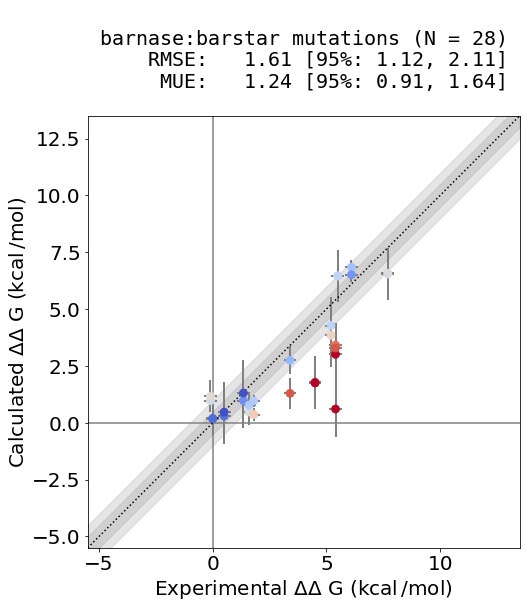

In [14]:
# Format data appropriately
x = [edge[2]["exp_DDG"] for edge in fe.graph.edges(data=True)]
y = [edge[2]["calc_DDG"] for edge in fe.graph.edges(data=True)]
xerr = np.asarray([edge[2]["exp_dDDG"] for edge in fe.graph.edges(data=True)])
yerr = np.asarray([edge[2]["calc_dDDG"] for edge in fe.graph.edges(data=True)])
x_data = np.asarray(x)
y_data = np.asarray(y)

# Generate the plot
filename = '/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/cinnabar_plot_longer_all_50ns.pdf'
plot = plotting._master_plot(
    x_data,
    y_data,
    xerr=xerr,
    yerr=yerr,
    filename=filename,
    title="",
    target_name="barnase:barstar mutations",
    units=r'$\mathrm{kcal\,/mol}$', 
    figsize=10, 
    dpi=500,
    xy_lim=[-5.5, 13.5],
#    data_labels=labels_accuracy,
#     data_labels=titles,
    font_sizes={"title":20, "labels": 20, "other": 20},
    scatter_kwargs={'s': 60}
)

## -Reverse vs Forward plot

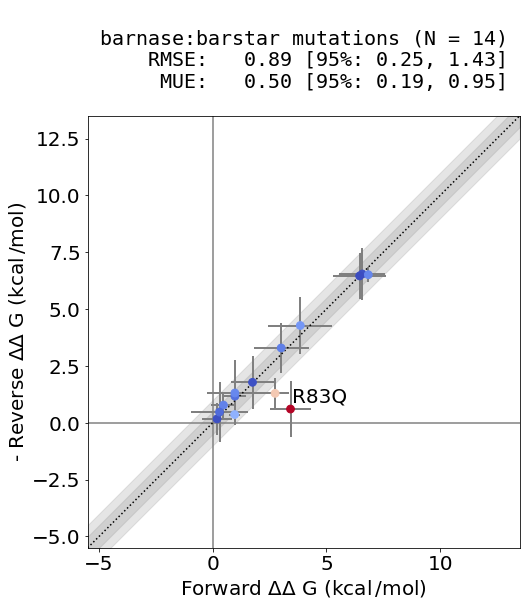

In [15]:
# Format the data appropriately
x = [entry[2] for i, entry in enumerate(to_plot) if i < 14] # forward
y = [entry[2] for i, entry in enumerate(to_plot) if i >= 14] # reverse
xerr =  [entry[3] for i, entry in enumerate(to_plot) if i < 14] # forward
yerr = [entry[3] for i, entry in enumerate(to_plot) if i >= 14] # reverse
x_data = np.asarray(x)
y_data = np.asarray(y)

# Generate the plot
filename = '/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/cinnabar_plot_longer_internal_consistency_all_50ns.pdf'
plot = plotting._master_plot(
    x_data,
    y_data,
    xerr=xerr,
    yerr=yerr,
    filename=filename,
    title="",
    target_name="barnase:barstar mutations",
    xlabel="Forward",
    ylabel="- Reverse",
    units=r'$\mathrm{kcal\,/mol}$', 
    figsize=10, 
    dpi=500,
    xy_lim=[-5.5, 13.5],
    data_labels=labels_internal_consistency,
    font_sizes={"title":20, "labels": 20, "other": 20},
    scatter_kwargs={'s': 60}
)


## Table

### 50 ns/replica complex, 10 ns/replica apo

In [60]:
# Format the data appropriately for table

titles = ["Y29F", "Y29A",  "W38F", "T42A", "W44F", "E76A", "E80A", "D35A", "D39A", "K27A", "R59A", "R83Q", "R87A", "H102A", "F29Y", "A29Y",  "F38W", "A42T", "F44W", "A76E", "A80E", "A35D", "A39D", "A27K", "A59R", "Q83R", "A87R", "A102H"]
experiment = [-0.1, 3.4, 1.6, 1.8, 0, 1.4, 0.5, 4.5, 7.7, 5.4, 5.2, 5.4, 5.5, 6.1, 0.1, -3.4, -1.6, -1.8, 0, -1.4, -0.5, -4.5, -7.7, -5.4, -5.2, -5.4, -5.5, -6.1]

to_plot = []

for sub_dir in range(28):
    ddg = compute_ddg(d_results[sub_dir]['apo']["Deltaf"][0, -1], d_results[sub_dir]['complex']["Deltaf"][0, -1])
    dddg = compute_error(d_results[sub_dir]['apo']["dDeltaf"][0, -1], d_results[sub_dir]['complex']["dDeltaf"][0, -1])
    if sub_dir in range(14):
        to_plot.append([titles[sub_dir], round(ddg, 2), round(dddg, 2), experiment[sub_dir], 50, 10, "forward"])
    else:
        to_plot.append([titles[sub_dir], round(ddg, 2), round(dddg, 2), experiment[sub_dir], 50, 10, "reverse"])


### 100 ns/replica complex, 10 ns/replica apo

In [61]:
# Retrieve free energies for 100 ns

replicate = 1
main_dir = 47
sub_dirs = [25]

d_results = {}
for sub_dir in sub_dirs:
    d_results[sub_dir] = {}
    for phase in ['apo', 'complex']:
        if phase == "complex":
            length = 100
        else:
            length = 10
        with open(f"/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/{main_dir}/{sub_dir}/replicate_{replicate}/{phase}_free_energy_bootstrapped_{length}ns.pickle", "rb") as f:
            results = pickle.load(f)
            d_results[sub_dir][phase] = results


In [62]:
# Format the data appropriately for table

titles = ["Y29F", "Y29A",  "W38F", "T42A", "W44F", "E76A", "E80A", "D35A", "D39A", "K27A", "R59A", "R83Q", "R87A", "H102A", "F29Y", "A29Y",  "F38W", "A42T", "F44W", "A76E", "A80E", "A35D", "A39D", "A27K", "A59R", "Q83R", "A87R", "A102H"]

for sub_dir in [25]:
    ddg = compute_ddg(d_results[sub_dir]['apo']["Deltaf"][0, -1], d_results[sub_dir]['complex']["Deltaf"][0, -1])
    dddg = compute_error(d_results[sub_dir]['apo']["dDeltaf"][0, -1], d_results[sub_dir]['complex']["dDeltaf"][0, -1])
    if sub_dir in range(14):
        to_plot.append([titles[sub_dir], round(ddg, 2), round(dddg, 2), experiment[sub_dir], 100, 10, "forward"])
    else:
        to_plot.append([titles[sub_dir], round(ddg, 2), round(dddg, 2), experiment[sub_dir], 100, 10, "reverse"])


In [63]:
to_plot

[['Y29F', 0.97, 0.25, -0.1, 50, 10, 'forward'],
 ['Y29A', 2.74, 0.31, 3.4, 50, 10, 'forward'],
 ['W38F', 0.47, 0.28, 1.6, 50, 10, 'forward'],
 ['T42A', 0.96, 0.12, 1.8, 50, 10, 'forward'],
 ['W44F', 0.19, 0.33, 0, 50, 10, 'forward'],
 ['E76A', 0.97, 0.6, 1.4, 50, 10, 'forward'],
 ['E80A', 0.3, 0.62, 0.5, 50, 10, 'forward'],
 ['D35A', 1.75, 0.48, 4.5, 50, 10, 'forward'],
 ['D39A', 6.58, 0.51, 7.7, 50, 10, 'forward'],
 ['K27A', 3.01, 0.6, 5.4, 50, 10, 'forward'],
 ['R59A', 3.85, 0.7, 5.2, 50, 10, 'forward'],
 ['R83Q', 3.42, 0.46, 5.4, 50, 10, 'forward'],
 ['R87A', 6.46, 0.58, 5.5, 50, 10, 'forward'],
 ['H102A', 6.84, 0.16, 6.1, 50, 10, 'forward'],
 ['F29Y', -1.17, 0.36, 0.1, 50, 10, 'reverse'],
 ['A29Y', -1.29, 0.34, -3.4, 50, 10, 'reverse'],
 ['F38W', -0.78, 0.28, -1.6, 50, 10, 'reverse'],
 ['A42T', -0.36, 0.13, -1.8, 50, 10, 'reverse'],
 ['F44W', -0.17, 0.35, 0, 50, 10, 'reverse'],
 ['A76E', -1.31, 0.72, -1.4, 50, 10, 'reverse'],
 ['A80E', -0.47, 0.66, -0.5, 50, 10, 'reverse'],
 ['A35D

In [68]:
df = pd.DataFrame(to_plot, columns=["Mutation", r"Predicted $\Delta\Delta$G (kcal/mol)", "Error (kcal/mol)", "Experimental $\Delta\Delta$G (kcal/mol)", "Complex phase simulation time (ns/replica)", "Apo phase simulation time (ns/replica)", "Mutation direction"])

In [69]:
df

,Mutation,Predicted $\Delta\Delta$G (kcal/mol),Error (kcal/mol),Experimental $\Delta\Delta$G (kcal/mol),Complex phase simulation time (ns/replica),Apo phase simulation time (ns/replica),Mutation direction
0,Y29F,0.97,0.25,-0.1,50,10,forward
1,Y29A,2.74,0.31,3.4,50,10,forward
2,W38F,0.47,0.28,1.6,50,10,forward
3,T42A,0.96,0.12,1.8,50,10,forward
4,W44F,0.19,0.33,0.0,50,10,forward
5,E76A,0.97,0.60,1.4,50,10,forward
6,E80A,0.30,0.62,0.5,50,10,forward
7,D35A,1.75,0.48,4.5,50,10,forward
8,D39A,6.58,0.51,7.7,50,10,forward
9,K27A,3.01,0.60,5.4,50,10,forward


In [70]:
df.to_excel("/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/table_50ns_arex.xlsx", index=False)

In [71]:
df.to_csv("/data/chodera/zhangi/perses_benchmark/repex/perses-bnbs-paper-fourth-attempt/table_50ns_arex.csv", index=False)